# Load data and clone source repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import shutil
import zipfile
import os

if not os.path.isdir('OMS2CD'):
    with zipfile.ZipFile('/datasets/oms2cd_subset/OMS2CD_subset.zip', 'r') as zip_ref:
        zip_ref.extractall('OMS2CD')

if not os.path.isdir('TestData'):
    with zipfile.ZipFile('/datasets/jasanskytest/Jasansky_2023_rgb_after2019.zip', 'r') as zip_ref:
        zip_ref.extractall('TestData')

if not os.path.isdir('TestDataIR'):
    with zipfile.ZipFile('/datasets/jasanskytestir/Jasansky_2023_rgbir_after2019.zip', 'r') as zip_ref:
        zip_ref.extractall('TestDataIR')

In [1]:
!git clone https://github.com/Dibz15/OpenMineChangeDetection.git
import sys
sys.path.append('OpenMineChangeDetection/')

fatal: destination path 'OpenMineChangeDetection' already exists and is not an empty directory.


# Install dependencies

In [2]:
%%capture
!pip install rasterio==1.3.8
!pip install torchgeo==0.4.1
!pip install tiler==0.5.7
!pip install kornia==0.6.12
!pip install lightning==1.9.5
!pip install torchmetrics==0.11.4

# Seed random, set device

In [3]:
import torch
import random
import numpy as np

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

torch.manual_seed(543)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(543)
random.seed(543)
np.random.seed(543)

In [5]:
import kornia.augmentation as K
from OpenMineChangeDetection.datasets import OMS2CD

normalize_sample = OMS2CD.GetNormalizeTransform(bands='rgb')
normalize_batch = K.Normalize(mean=normalize_sample.mean, std=normalize_sample.std)

def get_mask_preds_tinycd(model, batch, device):
    batch = {k: v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
    batch['image'] = normalize_batch(batch['image'])
    mask_pred = model(batch['image']).squeeze(1)
    return mask_pred

def get_mask_preds_lsnet(model, batch, device):
    batch = {k: v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
    batch['image'] = normalize_batch(batch['image'])
    mask_pred = model(batch)
    mask_pred = mask_pred[-1]
    mask_pred_prob = torch.softmax(mask_pred, dim=1)
    mask_pred_prob_class1 = mask_pred_prob[:, 1, :, :]
    return mask_pred_prob_class1
 
def get_mask_preds_ddpmcd(model, batch, device):
    batch = {k: v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
    batch['image'] = normalize_batch(batch['image'])
    mask_pred = model(batch)
    mask_pred_prob = torch.softmax(mask_pred, dim=1)
    mask_pred_prob_class1 = mask_pred_prob[:, 1, :, :]
    return mask_pred_prob_class1

# Load case study data

In [6]:
from OpenMineChangeDetection.datasets.CaseStudyDataset
dataset = CaseStudyDataset('TestData', stride=200)

# Define visualisation functions

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def predict_file_mask(model, dataset, pred_func, device, file_index, threshold=None, plot=False, output_path=None):
    batch_size = 3 # Set your batch size
    image_tile_map = dataset.get_image_tile_ranges()
    chip_idx_range = image_tile_map[file_index]
    tiler, full_image_shape = dataset._get_tiler(file_index, channels_override = 1)

    full_meta = dataset.get_tile_metadata(chip_idx_range[0], mask = True, no_tile = True)
    merger_out = Merger(tiler)

    tile_batch = []
    tile_ids = []
    for absolute_chip_id in range(chip_idx_range[0], chip_idx_range[1]+1):
        relative_tile_id = absolute_chip_id - chip_idx_range[0]
        tile_dict = dataset[absolute_chip_id]
        tile_batch.append(tile_dict)
        tile_ids.append(relative_tile_id)

        # Check if batch is full or if we are at the end of the loop
        if len(tile_batch) == batch_size or absolute_chip_id == chip_idx_range[1]:
            batch_input = torch.stack([tile['image'] for tile in tile_batch]).to(device)

            mask_pred_batch = pred_func(model, {'image': batch_input}, device)
            for i, mask_pred in enumerate(mask_pred_batch):
                mask_pred_numpy = mask_pred.unsqueeze(0).detach().cpu().numpy()
                merger_out.add(tile_ids[i], mask_pred_numpy)

            # Reset the batch
            tile_batch = []
            tile_ids = []

    final_mask = merger_out.merge(unpad=True).squeeze(0)
    if threshold is not None:
        final_mask = final_mask > threshold
    if plot:
        plt.figure()
        plt.imshow(final_mask)
        plt.show()

    if output_path is not None:
        with rasterio.open(output_path, 'w', **full_meta) as dst:
            dst.write((final_mask * 255).astype(np.uint8), 1)

    return final_mask, (full_image_shape[1]*full_image_shape[2])


In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors

def create_timeline_mask(date_list, mask_list, date_range_list, path=None):
    # Create a color-coded plot for this facility
    # Normalize dates to the range [0, 1] for color mapping
    min_date, max_date = pd.to_datetime(min(date_list)), pd.to_datetime(max(date_list))
    if min_date != max_date:
        norm_dates = [(pd.to_datetime(d) - min_date) / (max_date - min_date) for d in date_list]
    else:
        norm_dates = [0.5] * len(date_list)

    cmap = plt.get_cmap('viridis')
    hybrid_mask = np.zeros((*mask_list[0].shape, 3))  # Initialize with zeros, expecting 3D data for RGB
    for mask, norm_date in zip(mask_list, norm_dates):
        # Replace hybrid_mask with color-coded mask where mask == 1
        hybrid_mask[mask == 1] = np.array(cmap(norm_date))[:3]  # Take RGB, ignore alpha

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(hybrid_mask, alpha=0.6)

    # Create legend
    custom_lines = [Line2D([0], [0], color=cmap(i / (len(date_list)-1)), lw=4) for i in range(len(date_list))]
    ax.legend(custom_lines, [str(d) for d in sorted(date_range_list)], title='Dates', loc='upper right')

    if path is not None:
        # Save the figure for this facility
        plt.savefig(path, dpi=300)
    else:
        plt.show()
    plt.close()

def predict_masks(model, dataset, pred_func, device, threshold=None, output_dir=None, filter_area=False, facilities=None):
    change_list = []
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
    if facilities is None:
        facilities = dataset.get_facilities()

    for facility in tqdm(sorted(facilities)):
        facility_file_indices = dataset.get_facility_file_indices(facility)
        mask_list = []
        date_list = []
        cumulative_mask = None  # Initialize the cumulative mask

        if filter_area:
            area_mask_path = os.path.join(dataset.root_dir, 'area_mask', f'{facility}.tif')
            if os.path.isfile(area_mask_path):
                area_mask, _ = dataset._load_image(area_mask_path)
                area_mask = np.clip(area_mask, a_min=0, a_max=1).astype(np.uint8)
                area_mask = area_mask.squeeze(0)

        date_range_list = []  # This will store the date ranges for each file index
        for file_index in facility_file_indices:
            file_info = dataset.file_list[file_index]
            predate, postdate = file_info[3:5]
            date_range_list.append(f"{predate} - {postdate}")

            if output_dir is not None:
                output_path = os.path.join(output_dir, f'pred_{facility}_{file_index}_{predate}_{postdate}.tif')
            else:
                output_path = None

            mask, image_pixels = predict_file_mask(model, dataset, pred_func, device, file_index, threshold, plot=False, output_path=output_path)
            if filter_area:
                mask = mask & area_mask

            if cumulative_mask is None:
                cumulative_mask = mask  # Start with the first mask
            else:
                cumulative_mask = np.logical_or(cumulative_mask, mask)  # Logical OR operation

            cumulative_area_change = cumulative_mask.sum() * 100  # Total unique area change

            area_change = mask.sum() * 100  # (each pixel is 100 m^2)
            image_area = image_pixels * 100  # each pixel is 100m^2
            prop = float(area_change) / float(image_area)
            cumu_prop = float(cumulative_area_change) / float(image_area)
            # Append the mask and dates to the respective lists
            mask_list.append(mask)
            date_list.append(postdate)  # We only need postdate for coloring

            change_list.append({"facility": facility, "index": file_index,
                                "predate": predate, "postdate": postdate,
                                "change_area": area_change, "image_area": image_area,
                                "proportion": prop, "cumulative_area": cumulative_area_change,
                                "cumulative_prop": cumu_prop})

        if output_dir is not None:
            create_timeline_mask(date_list, mask_list, date_range_list,
                                path=os.path.join(output_dir, f'{facility}_hybrid_mask.png'))

    return pd.DataFrame(change_list)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_changes_multimodel(df, facilities, yvar='change_area', add_median=False, path=None, inclusions=None):
    df = df.copy()
    df['predate'] = pd.to_datetime(df['predate'])
    df['postdate'] = pd.to_datetime(df['postdate'])

    df = df.sort_values('predate')

    sns.set(style="whitegrid")

    models = df['model'].unique()

    if isinstance(facilities, str):
        facilities = [facilities]

    fig, axs = plt.subplots(len(facilities), 1, figsize=(14, 8*len(facilities)))

    # If only one subplot, put axs into a list
    if len(facilities) == 1:
        axs = [axs]

    for f, facility in enumerate(facilities):
        # Filter data for the chosen facility
        data = df[df['facility'] == facility]

        # Generate unique colors for each model
        colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
        medians = []
        stds = []
        dates = []

        # Get unique intervals
        intervals = data[['predate', 'postdate']].drop_duplicates()

        for interval_index, interval_row in intervals.iterrows():
            interval_values = []

            for i, model in enumerate(models):
                model_data = data[(data['model'] == model) &
                                  (data['predate'] == interval_row['predate']) &
                                  (data['postdate'] == interval_row['postdate'])]

                # Plotting each line with a unique color
                for _, row in model_data.iterrows():
                    if inclusions is None or (inclusions is not None and model in inclusions):
                        axs[f].plot([row['predate'], row['postdate']], [row[yvar], row[yvar]],
                                marker='o',
                                markeredgecolor='black', color=colors[i],
                                linestyle='-', label=model)

                    if model != 'GT': # Don't count ground truth into the median
                        # Add to interval values
                        interval_values.append(row[yvar])

            if add_median and interval_values:
                # Compute and store median for this interval
                median_val = np.median(interval_values)
                std_val = np.std(interval_values)
                medians.append(median_val)
                stds.append(std_val)
                # dates.append(interval_row['postdate'])
                midpoint_date = interval_row['predate'] + (interval_row['postdate'] - interval_row['predate']) / 2
                dates.append(midpoint_date)

        # Plot median line with error bars after all intervals are processed
        if add_median and medians:
            axs[f].errorbar(dates, medians, yerr=stds, fmt='o', color='red',
                            elinewidth=2, capsize=5, label='Median', linewidth=2)

        # Adding legend and labels
        axs[f].set_title(f'Change Over Time for {facility}')
        axs[f].set_xlabel('Time')
        axs[f].set_ylabel(yvar)

        # Ensure all model labels are included in the legend
        handles, labels = axs[f].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axs[f].legend(by_label.values(), by_label.keys(), title='Model')

    # Adjust the layout
    plt.tight_layout()

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.clf()

    plt.close()

# Load models

In [ ]:
from OpenMineChangeDetection.utils import load_tinycd_oms2cd, load_lsnet_oms2cd, load_ddpmcd_oms2cd
tinycd = load_tinycd_oms2cd(device)
lsnet = load_lsnet_oms2cd(device)
ddpmcd = load_ddpmcd_oms2cd(device)

# Make case study mask predictions

In [12]:
def predict_case_study_masks(root, threshold=0.6):
    # Assume root is repo subdir
    threshroot = os.path.join(root, 'modelchanges', str(threshold))
    os.makedirs(threshroot, exist_ok=True)
    print('Predicting TinyCD masks')
    tinycd_changes = predict_masks(tinycd, dataset, get_mask_preds_tinycd, device,
                                   threshold=threshold, output_dir=os.path.join(threshroot, 'masks_tinycd'), filter_area=False)
    tinycd_changes['model'] = 'TinyCD'

    print('Predicting LSNet masks')
    lsnet_changes = predict_masks(lsnet, dataset, get_mask_preds_lsnet, device,
                                  threshold=threshold, output_dir=os.path.join(threshroot, 'masks_lsnet'), filter_area=False)
    lsnet_changes['model'] = 'LSNet'
    print('Predicting DDPM-CD masks')
    ddpmcd_changes = predict_masks(ddpmcd, dataset, get_mask_preds_ddpmcd, device,
                                   threshold=threshold, output_dir=os.path.join(threshroot, 'masks_ddpmcd'), filter_area=False)
    ddpmcd_changes['model'] = 'DDPMCD'

    modeldf = pd.concat([tinycd_changes, lsnet_changes, ddpmcd_changes], ignore_index=True)
    modeldf.to_csv(os.path.join(threshroot, 'model_changes.csv'), index=False)

    # modeldf = pd.read_csv(os.path.join(threshroot, 'model_changes.csv'))

    model_names = modeldf['model'].unique()
    site_names = modeldf['facility'].unique()

    for facility in site_names:
        output_path_area = os.path.join(threshroot, f'{facility}_area.png')
        output_path_prop = os.path.join(threshroot, f'{facility}_prop.png')
        print(f'Plotting {facility} changes and saving to {output_path_area}.')
        plot_changes_multimodel(modeldf, [facility], yvar='change_area', add_median=True, path=output_path_area)
        plot_changes_multimodel(modeldf, [facility], yvar='proportion', add_median=True, path=output_path_prop)

        output_path_area = os.path.join(threshroot, f'{facility}_cumuarea.png')
        output_path_prop = os.path.join(threshroot, f'{facility}_cumuprop.png')
        print(f'Plotting {facility} changes and saving to {output_path_area}.')
        plot_changes_multimodel(modeldf, [facility], yvar='cumulative_area', add_median=True, path=output_path_area)
        plot_changes_multimodel(modeldf, [facility], yvar='cumulative_prop', add_median=True, path=output_path_prop)

In [13]:
with torch.no_grad():
    predict_case_study_masks('OpenMineChangeDetection/site_data', threshold=0.4)

Plotting Amazon changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Amazon_area.png.
Plotting Amazon changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Amazon_cumuarea.png.
Plotting Amazon_baseline changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Amazon_baseline_area.png.
Plotting Amazon_baseline changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Amazon_baseline_cumuarea.png.
Plotting Carrapateena changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Carrapateena_area.png.
Plotting Carrapateena changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Carrapateena_cumuarea.png.
Plotting Carrapateena_baseline changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Carrapateena_baseline_area.png.
Plotting Carrapateena_baseline changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Carrapateena_baseline_cumuarea.png.
Plotting Craters

In [14]:
predict_case_study_masks('OpenMineChangeDetection/site_data', threshold=0.6)

Plotting Amazon changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Amazon_area.png.
Plotting Amazon changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Amazon_cumuarea.png.
Plotting Amazon_baseline changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Amazon_baseline_area.png.
Plotting Amazon_baseline changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Amazon_baseline_cumuarea.png.
Plotting Carrapateena changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Carrapateena_area.png.
Plotting Carrapateena changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Carrapateena_cumuarea.png.
Plotting Carrapateena_baseline changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Carrapateena_baseline_area.png.
Plotting Carrapateena_baseline changes and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Carrapateena_baseline_cumuarea.png.
Plotting Craters

# Make NDVI/NDWI index visualisations

In [28]:
from torchgeo.transforms import AppendNDVI, AppendNDWI

def predict_index(dataset, index_func, device, file_index, plot=False, output_path=None):
    image_tile_map = dataset.get_image_tile_ranges()
    chip_idx_range = image_tile_map[file_index]
    tiler, full_image_shape = dataset._get_tiler(file_index, channels_override = 1)
    full_meta = dataset.get_tile_metadata(chip_idx_range[0], mask = True, no_tile = True)
    merger_out_pre = Merger(tiler)
    merger_out_post = Merger(tiler)

    for absolute_chip_id in range(chip_idx_range[0], chip_idx_range[1]+1):
        relative_tile_id = absolute_chip_id - chip_idx_range[0]
        tile_dict = dataset[absolute_chip_id]

        pre_index, post_index = index_func(tile_dict, device)
        pre_index_numpy = pre_index.detach().cpu().numpy()
        post_index_numpy = post_index.detach().cpu().numpy()
        merger_out_pre.add(relative_tile_id, pre_index_numpy)
        merger_out_post.add(relative_tile_id, post_index_numpy)

    final_index_pre = merger_out_pre.merge(unpad=True).squeeze(0)
    final_index_post = merger_out_post.merge(unpad=True).squeeze(0)

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
        img1 = axs[0].imshow(final_index_pre, cmap='RdYlGn', vmin=0, vmax=1)
        axs[0].set_title('Index Image 1')
        img2 = axs[1].imshow(final_index_post, cmap='RdYlGn', vmin=0, vmax=1)
        axs[1].set_title('Index Image 2')
        cbar = fig.colorbar(img1, ax=axs.ravel().tolist(), fraction=.1)
        cbar.set_label('Index')
        plt.show()

    if output_path is not None:
        with rasterio.open(output_path, 'w', **full_meta) as dst:
            dst.write((final_index_pre * 255).astype(np.uint8), 1)

    return final_index_pre, final_index_post, (full_image_shape[1]*full_image_shape[2])

In [29]:
def predict_indices(dataset, pred_func, device):
    change_list = []
    for facility in sorted(dataset.get_facilities()):
        facility_file_indices = dataset.get_facility_file_indices(facility)

        for file_index in facility_file_indices:
            file_info = dataset.file_list[file_index]
            predate, postdate = file_info[3:5]
            index_pre, index_post, image_pixels = predict_index(dataset, pred_func, device, file_index, plot=False, output_path=None)
            diff_img = index_post - index_pre
            area_change = diff_img.sum() * 100 # (each pixel is 100 m^2)
            image_area = image_pixels * 100 # each pixel is 100m^2
            prop = float(area_change) / float(image_area)
            # print(f'{facility}:{file_index}:{postdate} - {pixel_change}/{image_area} ({prop}).')
            change_list.append({ "facility": facility, "index": file_index, "predate": predate, "postdate": postdate, "change_area": area_change, "image_area": image_area, "proportion": prop })
    return pd.DataFrame(change_list)

In [30]:
ndvi = AppendNDVI(index_nir=3, index_red=0).to(device)
ndwi = AppendNDWI(index_nir=3, index_green=1).to(device)

def norm_index(img):
    return (img + 1) / 2

def predict_ndvi(sample, device):
    n_bands = 4 #RGB+NIR
    images = sample['image'].to(device)
    pre, post = images[0:n_bands, :], images[n_bands:2*n_bands, :]
    pre_ndvi_image = norm_index(ndvi(pre).squeeze(0)[-1])
    post_ndvi_image = norm_index(ndvi(post).squeeze(0)[-1])
    return pre_ndvi_image.unsqueeze(0), post_ndvi_image.unsqueeze(0)

def predict_ndwi(sample, device):
    n_bands = 4 #RGB+NIR
    images = sample['image'].to(device)
    pre, post = images[0:n_bands, :], images[n_bands:2*n_bands, :]
    pre_ndwi_image = norm_index(ndwi(pre).squeeze(0)[-1])
    post_ndwi_image = norm_index(ndwi(post).squeeze(0)[-1])
    return pre_ndwi_image.unsqueeze(0), post_ndwi_image.unsqueeze(0)

In [20]:
def predict_case_study_indices(root):
    datasetir = CaseStudyDataset('TestDataIR', stride=200)

    ndvi_changes = predict_indices(datasetir, predict_ndvi, device)
    ndvi_changes['model'] = 'NDVI'

    ndwi_changes = predict_indices(datasetir, predict_ndwi, device)
    ndwi_changes['model'] = 'NDWI'

    indexdf = pd.concat([ndvi_changes, ndwi_changes], ignore_index=True)
    indexdf.to_csv(os.path.join(root, 'index_changes.csv'), index=False)
    # indexdf = pd.read_csv(os.path.join(root, 'index_changes.csv'))
    model_names = indexdf['model'].unique()
    site_names = indexdf['facility'].unique()

    indexroot = os.path.join(root, 'indexchanges')
    os.makedirs(indexroot, exist_ok=True)

    indexdf['change_area'] = indexdf['change_area'].abs()
    indexdf['proportion'] = indexdf['proportion'].abs()

    for facility in site_names:
        output_path_area = os.path.join(indexroot, f'{facility}_area.png')
        output_path_prop = os.path.join(indexroot, f'{facility}_prop.png')
        print(f'Plotting {facility} changes and saving to {output_path_area}.')
        plot_changes_multimodel(indexdf, [facility], yvar='change_area', add_median=False, path=output_path_area)
        plot_changes_multimodel(indexdf, [facility], yvar='proportion', add_median=False, path=output_path_prop)

In [22]:
predict_case_study_indices('OpenMineChangeDetection/site_data')

Plotting Amazon changes and saving to OpenMineChangeDetection/site_data/indexchanges/Amazon_area.png.
Plotting Amazon_baseline changes and saving to OpenMineChangeDetection/site_data/indexchanges/Amazon_baseline_area.png.
Plotting Carrapateena changes and saving to OpenMineChangeDetection/site_data/indexchanges/Carrapateena_area.png.
Plotting Carrapateena_baseline changes and saving to OpenMineChangeDetection/site_data/indexchanges/Carrapateena_baseline_area.png.
Plotting Craters changes and saving to OpenMineChangeDetection/site_data/indexchanges/Craters_area.png.
Plotting Craters_baseline changes and saving to OpenMineChangeDetection/site_data/indexchanges/Craters_baseline_area.png.
Plotting Iluka Western Australia changes and saving to OpenMineChangeDetection/site_data/indexchanges/Iluka Western Australia_area.png.
Plotting Iluka Western Australia_baseline changes and saving to OpenMineChangeDetection/site_data/indexchanges/Iluka Western Australia_baseline_area.png.
Plotting London 

# Define ground-truth mask helper functions

In [29]:
import pandas as pd

def create_mapping(root):
    source_dir = root
    mapping_file_path = os.path.join(source_dir, 'mapping.csv')

    df = pd.read_csv(mapping_file_path)
    df.to_csv(os.path.join(source_dir, 'old_mapping.csv'))
    # Extract facility name
    df['facility'] = df['mask'].str.replace('.tif', '', regex=False)

    # Adjust predate and postdate to remove the '.tif'
    df['predate'] = df['imageA'].str.replace('.tif', '', regex=False)
    df['postdate'] = df['imageB'].str.replace('.tif', '', regex=False)

    # Extract predate and postdate
    df['predate'] = pd.to_datetime(df['predate'].str.split('_').str[-1])
    df['postdate'] = pd.to_datetime(df['postdate'].str.split('_').str[-1])

    df.to_csv(mapping_file_path)
    return df

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

def predict_masks_validated(dataset, facilities, output_dir=None):
    change_list = []
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
    for facility in sorted(facilities):
        facility_file_indices = dataset.get_facility_file_indices(facility)
        cumulative_mask = None
        mask_list = []
        date_list = []
        date_range_list = []
        for file_index in facility_file_indices:
            file_info = dataset.file_list[file_index]
            predate, postdate = file_info[3:5]
            date_range_list.append(f"{predate} - {postdate}")

            mask_id = file_info[5]
            mask_path = os.path.join(dataset.root_dir, 'mask', f'{facility}_{str(mask_id).zfill(4)}.tif')

            if os.path.isfile(mask_path):
                mask, _ = dataset._load_image(mask_path)
                mask = np.clip(mask, a_min=0, a_max=1).astype(np.uint8)

                if cumulative_mask is None:
                    cumulative_mask = mask  # Start with the first mask
                else:
                    cumulative_mask = np.logical_or(cumulative_mask, mask)  # Logical OR operation

                cumulative_area_change = cumulative_mask.sum() * 100  # Total unique area change

                shape = list(mask.shape)
                image_pixels = shape[1] * shape[2]
                area_change = mask.sum() * 100 # (each pixel is 100 m^2)
                image_area = image_pixels * 100 # each pixel is 100m^2
                prop = float(area_change) / float(image_area)
                cumu_prop = float(cumulative_area_change) / float(image_area)
                mask_list.append(mask.squeeze(0))
                date_list.append(postdate)  # We only need postdate for coloring

            # print(f'{facility}:{file_index}:{postdate} - {pixel_change}/{image_area} ({prop}).')
                change_list.append({ "facility": facility, "index": file_index,
                                    "predate": predate, "postdate": postdate,
                                     "change_area": area_change, "image_area": image_area,
                                     "proportion": prop, "cumulative_area": cumulative_area_change,
                                     "cumulative_prop": cumu_prop})
                # break
        # break
        if output_dir is not None:
            create_timeline_mask(date_list, mask_list, date_range_list,
                                path=os.path.join(output_dir, f'{facility}_hybrid_mask_GT.png'))

    df = pd.DataFrame(change_list)
    df['model'] = 'GT'
    return df

In [30]:
def get_facilities(split, dataset):
    valid_facilities = set()
    split_file_path = os.path.join(dataset.root_dir, f'{split}.csv')
    with open(split_file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        valid_facilities = set([str(row[0]) for row in reader])
    return list(valid_facilities)

# Prepare OMS2CD for evaluation

In [31]:
create_mapping('OMS2CD')
dataset_oms2cd = CaseStudyDataset('OMS2CD', stride=200)

# Predict 'validated' (with ground-truth) mask outputs

In [37]:
val_validated_df = predict_masks_validated(dataset_oms2cd, get_facilities('val', dataset_oms2cd), output_dir='OpenMineChangeDetection/site_data/modelchanges_validated')
test_validated_df = predict_masks_validated(dataset_oms2cd, get_facilities('test', dataset_oms2cd), output_dir='OpenMineChangeDetection/site_data/modelchanges_validated')

In [17]:
def predict_all_validated_masks(root, threshold=0.6, filter_area=True):
    threshroot = os.path.join(root, 'modelchanges_validated', str(threshold))
    os.makedirs(threshroot, exist_ok=True)
    tinycd_val_changes = predict_masks(tinycd, dataset_oms2cd,
                                      get_mask_preds_tinycd, device,
                                      facilities=get_facilities('val', dataset_oms2cd),
                                      threshold=threshold,
                                      output_dir=os.path.join(threshroot, 'masks_tinycd'),
                                      filter_area=filter_area)
    tinycd_val_changes['model'] = 'TinyCD'
    tinycd_test_changes = predict_masks(tinycd, dataset_oms2cd,
                                        get_mask_preds_tinycd, device,
                                        facilities=get_facilities('test', dataset_oms2cd),
                                        threshold=threshold,
                                        output_dir=os.path.join(threshroot, 'masks_tinycd'),
                                        filter_area=filter_area)
    tinycd_test_changes['model'] = 'TinyCD'

    lsnet_val_changes = predict_masks(lsnet, dataset_oms2cd,
                                      get_mask_preds_lsnet, device,
                                      facilities=get_facilities('val', dataset_oms2cd),
                                      threshold=threshold,
                                      output_dir=os.path.join(threshroot, 'masks_lsnet'),
                                      filter_area=filter_area)
    lsnet_val_changes['model'] = 'LSNet'
    lsnet_test_changes = predict_masks(lsnet, dataset_oms2cd,
                                      get_mask_preds_lsnet, device,
                                      facilities=get_facilities('test', dataset_oms2cd),
                                      threshold=threshold,
                                      output_dir=os.path.join(threshroot, 'masks_lsnet'),
                                      filter_area=filter_area)
    lsnet_test_changes['model'] = 'LSNet'

    ddpmcd_val_changes = predict_masks(ddpmcd, dataset_oms2cd,
                                      get_mask_preds_ddpmcd, device,
                                      facilities=get_facilities('val', dataset_oms2cd),
                                      threshold=threshold,
                                      output_dir=os.path.join(threshroot, 'masks_ddpmcd'),
                                      filter_area=filter_area)
    ddpmcd_val_changes['model'] = 'DDPMCD'
    ddpmcd_test_changes = predict_masks(ddpmcd, dataset_oms2cd,
                                        get_mask_preds_ddpmcd, device,
                                        facilities=get_facilities('test', dataset_oms2cd),
                                        threshold=threshold,
                                        output_dir=os.path.join(threshroot, 'masks_ddpmcd'),
                                        filter_area=filter_area)
    ddpmcd_test_changes['model'] = 'DDPMCD'

    modeldf = pd.concat([val_validated_df, test_validated_df,
                                  tinycd_val_changes, tinycd_test_changes,
                                  lsnet_val_changes, lsnet_test_changes,
                                  ddpmcd_val_changes, ddpmcd_test_changes], ignore_index=True)
    # modeldf.to_csv(os.path.join(threshroot, 'model_changes_validated.csv'))
    modeldf = pd.read_csv(os.path.join(threshroot, 'model_changes_validated.csv'))
    model_names = modeldf['model'].unique()
    site_names = modeldf['facility'].unique()

    for facility in site_names:
        output_path_area = os.path.join(threshroot, f'{facility}_area.png')
        output_path_prop = os.path.join(threshroot, f'{facility}_prop.png')
        print(f'Plotting {facility} changes and saving to {output_path_area}.')
        plot_changes_multimodel(modeldf, [facility], yvar='change_area', add_median=True, path=output_path_area)
        plot_changes_multimodel(modeldf, [facility], yvar='proportion', add_median=True, path=output_path_prop)

        output_path_area = os.path.join(threshroot, f'{facility}_cumuarea.png')
        output_path_prop = os.path.join(threshroot, f'{facility}_cumuprop.png')
        plot_changes_multimodel(modeldf, [facility], yvar='cumulative_area', add_median=True, path=output_path_area)
        plot_changes_multimodel(modeldf, [facility], yvar='cumulative_prop', add_median=True, path=output_path_prop)

        output_path_area = os.path.join(threshroot, f'{facility}_area_medgt.png')
        output_path_prop = os.path.join(threshroot, f'{facility}_prop_medgt.png')
        plot_changes_multimodel(modeldf, [facility], yvar='change_area', add_median=True, path=output_path_area, inclusions=['GT'])
        plot_changes_multimodel(modeldf, [facility], yvar='proportion', add_median=True, path=output_path_prop, inclusions=['GT'])

        output_path_area = os.path.join(threshroot, f'{facility}_cumuarea_medgt.png')
        output_path_prop = os.path.join(threshroot, f'{facility}_cumuprop_medgt.png')
        plot_changes_multimodel(modeldf, [facility], yvar='cumulative_area', add_median=True, path=output_path_area, inclusions=['GT'])
        plot_changes_multimodel(modeldf, [facility], yvar='cumulative_prop', add_median=True, path=output_path_prop, inclusions=['GT'])

In [18]:
predict_all_validated_masks('OpenMineChangeDetection/site_data', threshold=0.4, filter_area=True)

Plotting Gunnedah_vickery changes and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.4/Gunnedah_vickery_area.png.
Plotting Werris Creek changes and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.4/Werris Creek_area.png.
Plotting Guizhou_Xiuwen changes and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.4/Guizhou_Xiuwen_area.png.
Plotting Mianchi changes and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.4/Mianchi_area.png.


In [19]:
predict_all_validated_masks('OpenMineChangeDetection/site_data', threshold=0.6, filter_area=True)

Plotting Gunnedah_vickery changes and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.6/Gunnedah_vickery_area.png.
Plotting Werris Creek changes and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.6/Werris Creek_area.png.
Plotting Guizhou_Xiuwen changes and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.6/Guizhou_Xiuwen_area.png.
Plotting Mianchi changes and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.6/Mianchi_area.png.


# NDTCI

## Define helper functions

In [39]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

def calculate_average_mask(directory, facility_name='', ignore=[], prefix='pred_'):
    # Find all GeoTIFF files in the directory
    mask_files = glob.glob(os.path.join(directory, f'{prefix}{facility_name}*.tif'))

    masks = []

    # Read each mask file
    for mask_file in mask_files:
        if mask_file.endswith('_NDTCI.tif'):
            continue
        
        on_ignore_list = False
        for i in ignore:
            if i in mask_file:
                on_ignore_list = True
                break
        if on_ignore_list:
            continue
        with rasterio.open(mask_file) as src:
            mask = src.read(1)  # Reading the first band
            mask = np.clip(mask, a_min=0, a_max=1).astype(float)
            masks.append(mask)
    
    # Convert the list of masks to a 3D numpy array and calculate the average
    average_mask = np.mean(masks, axis=0)
    
    return average_mask

def calculate_x_stable(average_mask, quantile=0.25):
    # Flatten the average mask to a 1D array
    flat_mask = average_mask.flatten()

    # Calculate the value at the given quantile
    x_stable = np.quantile(flat_mask, quantile)

    return x_stable


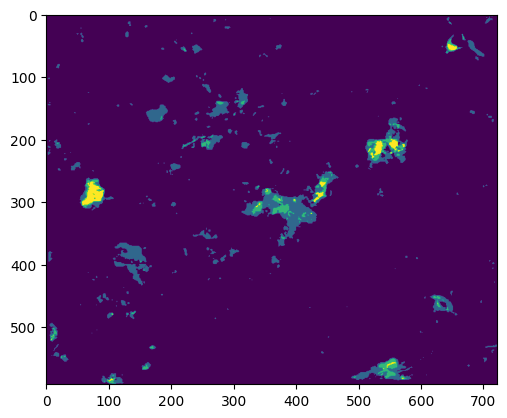

0.0


In [14]:


def calculate_NDTCI(input_filepath, x_stable, eps=1e-6, area_mask=None):
    # Open the GeoTIFF mask file
    with rasterio.open(input_filepath) as src:
        x_activity = src.read(1)  # Reading the first band
        x_activity = np.clip(x_activity, a_min=0, a_max=1).astype(float)
        if area_mask is not None:
            x_activity = (x_activity.astype(np.uint8) & area_mask.astype(np.uint8)).astype(float)
    # Compute the NDTCI
    NDTCI = (x_activity - x_stable) / (x_activity + x_stable + eps)
    
    # Normalize the NDTCI to [0, 1] for coloring
    # NDTCI_normalized = (NDTCI + 1) / 2    
    # Define a colormap to go from red/brown (high values) to blue/green (low values)
    colormap = plt.get_cmap('RdYlBu_r')

    # Apply the colormap to the NDTCI matrix (this will create a 3D array)
    NDTCI_color = colormap(NDTCI)[:,:,:3] # Cut out alpha channel from colormap result
    # Get the original metadata from the source file
    meta = src.meta
    meta.update(count=3, dtype=rasterio.uint8)
    
    return NDTCI, NDTCI_color, meta


In [15]:
def process_all_files(directory, out_dir='', x_stable=0.0, facility_name='', ignore=[]):
    # Find all GeoTIFF files in the directory
    mask_files = glob.glob(os.path.join(directory, f'*{facility_name}*.tif'))
    
    NDTCI_matrices = []
    meta = None
    
    if len(mask_files) == 0:
        print(f'No masks found in directory {directory}')
        return [], {}

    # Calculate the NDTCI for each mask file
    for mask_file in mask_files:
        if mask_file.endswith('_NDTCI.tif'):
            continue
        on_ignore_list = False
        for i in ignore:
            if i in mask_file:
                on_ignore_list = True
                break
        if on_ignore_list:
            continue
        output_filepath = mask_file.replace('.tif', '_NDTCI.tif')
        if len(out_dir):
            output_filepath = os.path.join(out_dir, os.path.basename(output_filepath))
        NDTCI, _, meta = calculate_NDTCI(mask_file, x_stable)
        NDTCI_matrices.append(NDTCI)
    
    return NDTCI_matrices, meta


In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

def write_average_NDTCI(NDTCI_matrices, output_filepath, meta):
    if len(NDTCI_matrices) == 0:
        print('No matrices given to calculate average NDTCI')
        return
    # Compute the average NDTCI matrix
    average_NDTCI = np.mean(NDTCI_matrices, axis=0)

    # Apply the colormap to the average NDTCI matrix (this will create a 3D array)
    colormap = plt.get_cmap('RdYlBu_r')
    average_NDTCI_color = colormap(average_NDTCI)[:,:,:3] # cut out alpha channel from colormap result

    # Write the average NDTCI GeoTIFF
    with rasterio.open(output_filepath, 'w', **meta) as dst:
        for channel in range(average_NDTCI_color.shape[2]):
            chc = average_NDTCI_color[:, :, channel]
            dst.write((chc * 255).astype(np.uint8), channel + 1)

    # Plotting the average NDTCI matrix
    fig, ax = plt.subplots()

    # Display the average NDTCI matrix using the colormap
    img = ax.imshow(average_NDTCI, cmap=colormap)
    # Create an axes for the colorbar
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Create a colorbar
    cbar = fig.colorbar(img, cax=cax)

    # Save the plot as a .png file
    plt.savefig(output_filepath.replace('.tif', '.png'))
    plt.close()



In [17]:
import pandas as pd

def create_ndtci_averages(root, threshold):
    threshroot = os.path.join(root, 'modelchanges', str(threshold))
    modeldf = pd.read_csv(os.path.join(threshroot, 'model_changes.csv'))
    model_names = modeldf['model'].unique()
    site_names = modeldf['facility'].unique()
    
    for model in model_names:
        print(model)
        for facility in site_names:
            # Set your directory
            directory = os.path.join(threshroot, f'masks_{model.lower()}')
            print(directory)
            output_directory = directory
            ignore = ['baseline']
            # Calculate the average mask
            average_mask = calculate_average_mask(directory, facility_name=facility, ignore=ignore)
            # Calculate x_stable
            x_stable = calculate_x_stable(average_mask, quantile=0.5)

            NDTCI_matrices, meta = process_all_files(directory, out_dir=output_directory, x_stable=x_stable, facility_name=facility, ignore=ignore)
            if len(NDTCI_matrices) == 0:
                continue
            # Set your output file path
            output_filepath = os.path.join(output_directory, f'{facility}_average_NDTCI.tif')

            write_average_NDTCI(NDTCI_matrices, output_filepath, meta)

## Create NDTCI avarages outputs

In [43]:
create_ndtci_averages('OpenMineChangeDetection/site_data', threshold=0.4)

TinyCD
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Amazon
0.0
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Amazon_baseline
nan
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Carrapateena
0.0


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Carrapateena_baseline
nan
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Craters
0.0
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Craters_baseline
nan
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Iluka Western Australia
0.0
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Iluka Western Australia_baseline
nan
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
London
0.0
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
London_baseline
nan
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Meliadine
0.0
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Meliadine_baseline
nan
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Merthyr Tydfil
0.0
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd
Merthyr Tydfil_baseline
nan
OpenMineChangeDetection/site_data/modelchanges/0.4/masks_

# More NDTCI helper/visualisation functions

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
import numpy as np

def predict_ndtci_masks(dataset, input_dir, output_dir, filter_area=False, facilities=None):
    change_list = []
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
    if facilities is None:
        facilities = dataset.get_facilities()

    for facility in tqdm(sorted(facilities)):
        facility_file_indices = dataset.get_facility_file_indices(facility)
        if filter_area:
            area_mask_path = os.path.join(dataset.root_dir, 'area_mask', f'{facility}.tif')
            if os.path.isfile(area_mask_path):
                area_mask, _ = dataset._load_image(area_mask_path)
                area_mask = np.clip(area_mask, a_min=0, a_max=1).astype(np.uint8)
                area_mask = area_mask.squeeze(0)

        if 'baseline' not in facility:
            ignore = ['baseline']
        else:
            ignore = []
            
        average_mask = calculate_average_mask(input_dir, facility_name=facility, ignore=ignore)
        x_stable = calculate_x_stable(average_mask, quantile=0.5)
        NDTCI_matrices = []
        if filter_area:
            NDTCI_matrices_masked = []
        meta = None
        date_range_list = []  # This will store the date ranges for each file index
        for file_index in facility_file_indices:
            file_info = dataset.file_list[file_index]
            predate, postdate = file_info[3:5]

            input_path = os.path.join(input_dir, f'pred_{facility}_{file_index}_{predate}_{postdate}.tif')
            
            NDTCI, _, meta = calculate_NDTCI(input_path, x_stable)
            NDTCI_matrices.append(NDTCI)
            shape = list(NDTCI.shape)
            
            if filter_area:
                NDTCI_masked, _, _ = calculate_NDTCI(input_path, x_stable, area_mask=area_mask)
                ndtci_mean = NDTCI_masked.sum() / (shape[0] * shape[1])
                NDTCI_matrices_masked.append(NDTCI_masked)
            else:
                ndtci_mean = NDTCI.sum() / (shape[0] * shape[1])

            change_list.append({"facility": facility, "index": file_index,
                                "predate": predate, "postdate": postdate,
                                "NDTCI": ndtci_mean})

        output_filepath = os.path.join(output_dir, f'{facility}_average_NDTCI.tif')
        write_average_NDTCI(NDTCI_matrices, output_filepath, meta)
        if filter_area:
            output_filepath = os.path.join(output_dir, f'{facility}_masked_average_NDTCI.tif')
            write_average_NDTCI(NDTCI_matrices_masked, output_filepath, meta)
            
    return pd.DataFrame(change_list)


def predict_ndtci_masks_validated(dataset, facilities, output_dir):
    change_list = []

    for facility in sorted(facilities):
        facility_file_indices = dataset.get_facility_file_indices(facility)
        if 'alt' not in facility:
            ignore = ['alt']
        else:
            ignore = []
        average_mask = calculate_average_mask(os.path.join(dataset.root_dir, 'mask'), facility_name=facility, ignore=ignore, prefix='')
        x_stable = calculate_x_stable(average_mask, quantile=0.5)
        NDTCI_matrices = []
        for file_index in facility_file_indices:
            file_info = dataset.file_list[file_index]
            predate, postdate = file_info[3:5]

            mask_id = file_info[5]
            mask_path = os.path.join(dataset.root_dir, 'mask', f'{facility}_{str(mask_id).zfill(4)}.tif')
            if os.path.isfile(mask_path):
                NDTCI, _, meta = calculate_NDTCI(mask_path, x_stable)
                NDTCI_matrices.append(NDTCI)
                shape = list(NDTCI.shape)
                ndtci_mean = NDTCI.sum() / (shape[0] * shape[1])
                change_list.append({"facility": facility, "index": file_index,
                                    "predate": predate, "postdate": postdate,
                                     "NDTCI": ndtci_mean})        

        output_filepath = os.path.join(output_dir, f'{facility}_GT_average_NDTCI.tif')
        write_average_NDTCI(NDTCI_matrices, output_filepath, meta)
        
    df = pd.DataFrame(change_list)
    df['model'] = 'GT'
    return df

In [43]:
def predict_all_ndtci_masks(root, threshold=0.4):
    threshroot = os.path.join(root, 'modelchanges', str(threshold))
    all_changes = []
    for model in ['DDPMCD', 'TinyCD', 'LSNet']:
        out_dir = os.path.join(threshroot, f'masks_{model.lower()}')
        print(f'Predicting NDTCI masks for {model} to output dir {out_dir}')
        model_changes = predict_ndtci_masks(dataset,
                                          facilities=dataset.get_facilities(),
                                          input_dir=out_dir,
                                          output_dir=out_dir,
                                          filter_area=False)
        model_changes['model'] = model
        all_changes.append(model_changes)

    modeldf = pd.concat(all_changes, ignore_index=True)
        
    model_names = modeldf['model'].unique()
    site_names = modeldf['facility'].unique()

    for facility in site_names:
        output_path_area = os.path.join(threshroot, f'{facility}_ndtci.png')
        print(f'Plotting {facility} NDTCI and saving to {output_path_area}.')
        plot_changes_multimodel(modeldf, [facility], yvar='NDTCI', add_median=True, path=output_path_area)

    modeldf.to_csv(os.path.join(threshroot, 'model_ndtci.csv'))
    
def predict_all_ndtci_masks_validated(root, threshold=0.4, filter_area=True):
    threshroot = os.path.join(root, 'modelchanges_validated', str(threshold))
    all_changes = []
    for model in ['DDPMCD', 'TinyCD', 'LSNet']:
        out_dir = os.path.join(threshroot, f'masks_{model.lower()}')
        print(f'Predicting NDTCI masks for {model} to output dir {out_dir}')
        for split in ['val', 'test']:
            model_changes = predict_ndtci_masks(dataset_oms2cd,
                                              facilities=get_facilities(split, dataset_oms2cd),
                                              input_dir=out_dir,
                                              output_dir=out_dir,
                                              filter_area=filter_area)
            model_changes['model'] = model
            all_changes.append(model_changes)

    print(f'Predicting GT NDTCI masks')
    all_changes.append(predict_ndtci_masks_validated(dataset_oms2cd, get_facilities('val', dataset_oms2cd), os.path.join(root, 'modelchanges_validated')))
    all_changes.append(predict_ndtci_masks_validated(dataset_oms2cd, get_facilities('test', dataset_oms2cd), os.path.join(root, 'modelchanges_validated')))
    
    modeldf = pd.concat(all_changes, ignore_index=True)
        
    model_names = modeldf['model'].unique()
    site_names = modeldf['facility'].unique()

    for facility in site_names:
        output_path_area = os.path.join(threshroot, f'{facility}_ndtci{"" if filter_area else "_nofilter"}.png')
        print(f'Plotting {facility} NDTCI and saving to {output_path_area}.')
        plot_changes_multimodel(modeldf, [facility], yvar='NDTCI', add_median=True, path=output_path_area)
        
        output_path_area_gt = os.path.join(threshroot, f'{facility}_ndtci_medgt{"" if filter_area else "_nofilter"}.png')
        plot_changes_multimodel(modeldf, [facility], yvar='NDTCI', add_median=True, path=output_path_area_gt, inclusions=['GT'])

    modeldf.to_csv(os.path.join(threshroot, f'model_ndtci_validated{"" if filter_area else "_nofilter"}.csv'))

In [108]:
predict_all_ndtci_masks('OpenMineChangeDetection/site_data', threshold=0.4)
predict_all_ndtci_masks('OpenMineChangeDetection/site_data', threshold=0.6)

Predicting NDTCI masks for DDPMCD to output dir OpenMineChangeDetection/site_data/modelchanges/0.4/masks_ddpmcd


100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


Predicting NDTCI masks for TinyCD to output dir OpenMineChangeDetection/site_data/modelchanges/0.4/masks_tinycd


100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


Predicting NDTCI masks for LSNet to output dir OpenMineChangeDetection/site_data/modelchanges/0.4/masks_lsnet


100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Plotting Amazon NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Amazon_ndtci.png.
Plotting Amazon_baseline NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Amazon_baseline_ndtci.png.
Plotting Carrapateena NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Carrapateena_ndtci.png.
Plotting Carrapateena_baseline NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Carrapateena_baseline_ndtci.png.
Plotting Craters NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Craters_ndtci.png.
Plotting Craters_baseline NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Craters_baseline_ndtci.png.
Plotting Iluka Western Australia NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Iluka Western Australia_ndtci.png.
Plotting Iluka Western Australia_baseline NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.4/Iluka Western Australia_baseline_ndt

100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Predicting NDTCI masks for TinyCD to output dir OpenMineChangeDetection/site_data/modelchanges/0.6/masks_tinycd


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


Predicting NDTCI masks for LSNet to output dir OpenMineChangeDetection/site_data/modelchanges/0.6/masks_lsnet


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Plotting Amazon NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Amazon_ndtci.png.
Plotting Amazon_baseline NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Amazon_baseline_ndtci.png.
Plotting Carrapateena NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Carrapateena_ndtci.png.
Plotting Carrapateena_baseline NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Carrapateena_baseline_ndtci.png.
Plotting Craters NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Craters_ndtci.png.
Plotting Craters_baseline NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Craters_baseline_ndtci.png.
Plotting Iluka Western Australia NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Iluka Western Australia_ndtci.png.
Plotting Iluka Western Australia_baseline NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges/0.6/Iluka Western Australia_baseline_ndt

In [45]:
predict_all_ndtci_masks_validated('OpenMineChangeDetection/site_data', threshold=0.4, filter_area=False)
predict_all_ndtci_masks_validated('OpenMineChangeDetection/site_data', threshold=0.6, filter_area=False)


Predicting NDTCI masks for DDPMCD to output dir OpenMineChangeDetection/site_data/modelchanges_validated/0.4/masks_ddpmcd


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Predicting NDTCI masks for TinyCD to output dir OpenMineChangeDetection/site_data/modelchanges_validated/0.4/masks_tinycd


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Predicting NDTCI masks for LSNet to output dir OpenMineChangeDetection/site_data/modelchanges_validated/0.4/masks_lsnet


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Predicting GT NDTCI masks
Plotting Gunnedah_vickery NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.4/Gunnedah_vickery_ndtci_nofilter.png.
Plotting Werris Creek NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.4/Werris Creek_ndtci_nofilter.png.
Plotting Guizhou_Xiuwen NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.4/Guizhou_Xiuwen_ndtci_nofilter.png.
Plotting Mianchi NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.4/Mianchi_ndtci_nofilter.png.
Predicting NDTCI masks for DDPMCD to output dir OpenMineChangeDetection/site_data/modelchanges_validated/0.6/masks_ddpmcd


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Predicting NDTCI masks for TinyCD to output dir OpenMineChangeDetection/site_data/modelchanges_validated/0.6/masks_tinycd


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Predicting NDTCI masks for LSNet to output dir OpenMineChangeDetection/site_data/modelchanges_validated/0.6/masks_lsnet


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Predicting GT NDTCI masks
Plotting Gunnedah_vickery NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.6/Gunnedah_vickery_ndtci_nofilter.png.
Plotting Werris Creek NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.6/Werris Creek_ndtci_nofilter.png.
Plotting Guizhou_Xiuwen NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.6/Guizhou_Xiuwen_ndtci_nofilter.png.
Plotting Mianchi NDTCI and saving to OpenMineChangeDetection/site_data/modelchanges_validated/0.6/Mianchi_ndtci_nofilter.png.


In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

def create_correlation_plot(df_path, var, title, output_path, gt=False):
    df = pd.read_csv(df_path)
    # Pivot the DataFrame so that each model's 'proportion' forms a column
    df_pivot = df.pivot_table(index=['facility', 'predate', 'postdate'], 
                              columns='model', values=var).reset_index()
    models = ['DDPMCD', 'TinyCD', 'LSNet']
    if gt:
        models.append('GT')
    df_pivot['Median'] = df_pivot[models].loc[:, df_pivot.dtypes != 'object'].median(axis=1)

    # Now, compute the correlation matrix specifying 'numeric_only=True'
    correlation_matrix = df_pivot.corr(numeric_only=True)

    # Also, compute a matrix of p-values
    p_value_matrix = correlation_matrix.copy()
    for col in correlation_matrix.columns:
        for row in correlation_matrix.index:
            if col != row:  # Skip when column and row are the same
                temp_df = df_pivot[[col, row]].dropna()
                try:
                    r, p_value = stats.pearsonr(temp_df[col].values, temp_df[row].values)
                    p_value_matrix.loc[row, col] = p_value
                except ValueError as e:
                    print(f"Failed to calculate pearson correlation for columns '{col}' and '{row}': {str(e)}")
                    p_value_matrix.loc[row, col] = np.nan
            else:  # If column and row are the same, set p-value to NaN (as it's not meaningful in this context)
                p_value_matrix.loc[row, col] = np.nan

    # Replace p-values with asterisks to denote their significance levels
    significance_level = 0.05  # Set a significance level
    p_value_matrix = p_value_matrix.applymap(lambda x: '***' if x < significance_level/100 else '**' if x < significance_level/10 else '*' if x < significance_level else '')

    # Combine correlation values with significance annotations
    combined_matrix = correlation_matrix.applymap('{:.2f}'.format) + "\n" + p_value_matrix
    # Create a heatmap of correlation coefficients, annotated with significance levels
    plt.figure(figsize=(10, 10))
    sns.heatmap(correlation_matrix, annot=combined_matrix, fmt='s', square=True, cmap='coolwarm', 
                xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns,
                vmin=0.4, vmax=1)

    plt.title(title)
    
    # Add a description of significance levels
    plt.text(0.33, 0.1, f'Significance levels: *: p<{significance_level:.2f}, **: p<{significance_level/10:.3f}, ***: p<{significance_level/100:.4f}', 
             size=10, ha="center", transform=plt.gcf().transFigure)
    plt.savefig(output_path)
    plt.show()


def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) ** 2).mean())

def calculate_rmse(df_path, var):
    df = pd.read_csv(df_path)
    # Pivot the DataFrame so that each model's 'proportion' forms a column
    df_pivot = df.pivot_table(index=['facility', 'predate', 'postdate'], 
                              columns='model', values=var).reset_index()
    models = ['DDPMCD', 'TinyCD', 'LSNet', 'GT']
    df_pivot['Median'] = df_pivot[models].loc[:, df_pivot.dtypes != 'object'].median(axis=1)
    df_pivot = df_pivot.dropna()
    models = ['DDPMCD', 'TinyCD', 'LSNet', 'Median']
    # Initialize an empty DataFrame to store the metrics
    metrics = []
    for model in models:
        # Calculate the RMSE
        rmse_value = rmse(df_pivot['GT'], df_pivot[model])

        # Append the metrics to the list
        metrics.append({'model': model, 'RMSE': rmse_value})
    
    return pd.DataFrame(metrics)

def plot_rmse(df_path1, df_path2, var, title, output_path):
    df_metrics1 = calculate_rmse(df_path1, var)
    df_metrics2 = calculate_rmse(df_path2, var)

    models = ['DDPMCD', 'TinyCD', 'LSNet', 'Median']

    # Setting the positions and width for the bars
    pos = list(range(len(df_metrics1['RMSE'])))
    width = 0.2
    print(df_metrics1)
    print(df_metrics2)
    # Plotting the bars
    fig, ax = plt.subplots(figsize=(7,5))

    # Create a bar with RMSE data from the first DataFrame
    plt.bar(pos,
            df_metrics1['RMSE'],
            width,
            # alpha=0.5,
            # color='#EE3224',
            label='with mask')

    # Create a bar with RMSE data from the second DataFrame,
    # in position pos + some width buffer
    plt.bar([p + width for p in pos],
            df_metrics2['RMSE'],
            width,
            # alpha=0.5,
            # color='#F78F1E',
            label='no mask')

    # Set the y axis label
    ax.set_ylabel('RMSE')

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_xticks([p + 0.5 * width for p in pos])

    # Set the labels for the x ticks
    ax.set_xticklabels(models)

    # Adding the legend and showing the plot
    plt.legend(loc='upper right')
    plt.grid()
    plt.savefig(output_path)
    plt.show()

# Use the function as:
# plot_rmse(df_path1, df_path2, var, title)

    model      RMSE
0  DDPMCD  0.004580
1  TinyCD  0.005734
2   LSNet  0.006129
3  Median  0.004028
    model      RMSE
0  DDPMCD  0.014549
1  TinyCD  0.006293
2   LSNet  0.010035
3  Median  0.006876


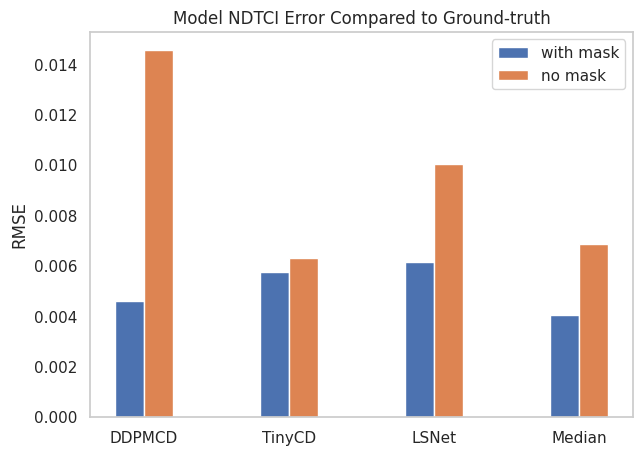

    model      RMSE
0  DDPMCD  0.007666
1  TinyCD  0.008895
2   LSNet  0.007790
3  Median  0.007157
    model      RMSE
0  DDPMCD  0.007241
1  TinyCD  0.007704
2   LSNet  0.008511
3  Median  0.005960


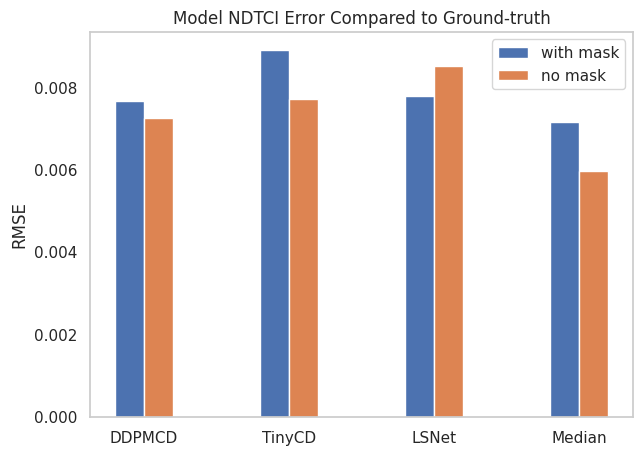

In [85]:
for sub in ['', '_validated']:
    if sub == '_validated':
        gt = True
    else:
        gt = False
    for filtering in (['', '_nofilter'] if gt else ['']):
        for thresh in [0.4, 0.6]:
            if filtering == '':
                create_correlation_plot(f'OpenMineChangeDetection/site_data/modelchanges{sub}/{str(thresh)}/model_changes{sub}{filtering}.csv', 
                                        'proportion', 
                                        'Model Correlation Matrix for Predicted Changes',
                                        f'OpenMineChangeDetection/site_data/modelchanges{sub}/{str(thresh)}/model_changes{sub}{filtering}_corr.png',
                                        gt)
                pass
            elif gt:
                plot_rmse(f'OpenMineChangeDetection/site_data/modelchanges_validated/{thresh}/model_ndtci_validated.csv',
                          f'OpenMineChangeDetection/site_data/modelchanges_validated/{thresh}/model_ndtci_validated_nofilter.csv',
                          'NDTCI',
                          'Model NDTCI Error Compared to Ground-truth',
                          f'OpenMineChangeDetection/site_data/modelchanges{sub}/{str(thresh)}/model_ndtci_err.png')

            create_correlation_plot(f'OpenMineChangeDetection/site_data/modelchanges{sub}/{str(thresh)}/model_ndtci{sub}{filtering}.csv', 
                                    'NDTCI', 
                                    'Model Correlation Matrix for NDTCI',
                                    f'OpenMineChangeDetection/site_data/modelchanges{sub}/{str(thresh)}/model_nctci{sub}{filtering}_corr.png',
                                    gt)
